# Introduction
"El Niño and the Southern Oscillation, also known as ENSO is a periodic fluctuation (i.e., every 2–7 years) in sea surface temperature (El Niño) and the air pressure of the overlying atmosphere (Southern Oscillation) across the equatorial Pacific Ocean.  The presence of an El Niño, or its opposite – La Niña – sufficiently modifies the general flow of the atmosphere to affect normal weather conditions in many parts of the world."

-NCEI

Learn more: https://www.ncei.noaa.gov/access/monitoring/enso/

# Problem
"ENSO prediction is one of the most challenging tasks in climatology. It is one of the main drivers of the interannual climate variability of Earth and can cause a wide range of climate anomalies. The impacts include natural disasters (floods, droughts), low & high agriculture yields, price fluctuation, energy demand, availability of water resources, animal movement, and many more."


# Primary Indicators
"The primary indicators for ENSO are ONI and MEI.v2. ONI, the preferred indicator by NOAA, is the 3-month average SST anomaly in the Niño 3.4 region. To be considered an El Niño/La Niña event, the SST anomalies in the Niño 3.4 region must meet the following criteria and remain at or above/below these levels for a minimum of five consecutive months."

- El Niño → anomalies at or above +0.5°C
- La Niña → anomalies at or below -0.5°C
- Neutral → anomalies between -0.5°C and +0.5°C

The threshold is further divided into:

- Weak → 0.5 to 0.9 °C SST anomaly
- Moderate → 1.0 to 1.4
- Strong → 1.5 to 1.9
- Very Strong → ≥ 2.0

In [433]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

from sklearn.preprocessing import LabelEncoder

from lazypredict.Supervised import LazyRegressor
import xgboost as xgb
from xgboost import plot_tree

from sklearn.model_selection import train_test_split

In [377]:
## Database extracted from: https://www.kaggle.com/datasets/shabanamir/enso-data

data = pd.read_csv("Enso.csv")

In [378]:
data.head()

,Date,Year,Month,Global Temperature Anomalies,Nino 1+2 SST,Nino 1+2 SST Anomalies,Nino 3 SST,Nino 3 SST Anomalies,Nino 3.4 SST,Nino 3.4 SST Anomalies,...,TNI,PNA,OLR,SOI,Season (2-Month),MEI.v2,Season (3-Month),ONI,Season (12-Month),ENSO Phase-Intensity
0,1/1/1950,1950,JAN,-0.20,NaN,NaN,NaN,NaN,NaN,NaN,...,0.62,-3.65,NaN,NaN,DJ,NaN,DJF,-1.50,1950-1951,ML
1,2/1/1950,1950,FEB,-0.26,NaN,NaN,NaN,NaN,NaN,NaN,...,0.45,-1.69,NaN,NaN,JF,NaN,JFM,-1.30,1950-1951,ML
2,3/1/1950,1950,MAR,-0.08,NaN,NaN,NaN,NaN,NaN,NaN,...,0.38,-0.06,NaN,NaN,FM,NaN,FMA,-1.20,1950-1951,ML
3,4/1/1950,1950,APR,-0.16,NaN,NaN,NaN,NaN,NaN,NaN,...,0.31,-0.23,NaN,NaN,MA,NaN,MAM,-1.20,1950-1951,ML
4,5/1/1950,1950,MAY,-0.02,NaN,NaN,NaN,NaN,NaN,NaN,...,0.12,-0.40,NaN,NaN,AM,NaN,AMJ,-1.10,1950-1951,ML


## Cleaning
This involves identifying and correcting errors or inconsistencies in the data, such as missing values, outliers and dublicates.

In [379]:
# We verify that there are no duplicate data

duplicated = data.duplicated()
num_duplicated = duplicated.sum()
print(f'There are {num_duplicated} duplicate rows')

There are 0 duplicate rows


In [380]:
# Now let's check the percentage of null data

nulls_p = (data.isna().sum()/len(data))*100
nulls_p = nulls_p.reset_index()
nulls_p.columns = ["Columns","Percentage"]
nulls_p

,Columns,Percentage
0,Date,0.00
1,Year,0.00
2,Month,0.00
3,Global Temperature Anomalies,0.00
4,Nino 1+2 SST,43.54
5,Nino 1+2 SST Anomalies,43.54
6,Nino 3 SST,43.54
7,Nino 3 SST Anomalies,43.54
8,Nino 3.4 SST,43.54
9,Nino 3.4 SST Anomalies,43.54


In [381]:
# I learned that if we have a percentage greater than 3 it is better to eliminate the entire 
# column since there is not much information provided and many times manipulating it can result 
# in a bad model.

columns_drop = nulls_p[nulls_p["Percentage"]>3]["Columns"]
columns_drop = columns_drop.values

In [382]:
data = data.drop(columns_drop,axis=1)

In [383]:
# In my opinion the exact date is not relevant data

data = data.drop("Date",axis=1)

In [384]:
# Since the SOI only had 1.36 percent of missing data, I decided to fill it in with the mean

data['SOI'].fillna(data['SOI'].mean(), inplace=True)

In [385]:
data

,Year,Month,Global Temperature Anomalies,TNI,PNA,SOI,Season (2-Month),Season (3-Month),ONI,Season (12-Month),ENSO Phase-Intensity
0,1950,JAN,-0.20,0.62,-3.65,0.15,DJ,DJF,-1.50,1950-1951,ML
1,1950,FEB,-0.26,0.45,-1.69,0.15,JF,JFM,-1.30,1950-1951,ML
2,1950,MAR,-0.08,0.38,-0.06,0.15,FM,FMA,-1.20,1950-1951,ML
3,1950,APR,-0.16,0.31,-0.23,0.15,MA,MAM,-1.20,1950-1951,ML
4,1950,MAY,-0.02,0.12,-0.40,0.15,AM,AMJ,-1.10,1950-1951,ML
...,...,...,...,...,...,...,...,...,...,...,...
877,2023,FEB,1.00,NaN,-1.15,1.40,JF,JFM,-0.40,2023-2024,NaN
878,2023,MAR,1.23,NaN,-1.89,0.20,FM,FMA,-0.10,2023-2024,NaN
879,2023,APR,0.98,NaN,-0.65,0.20,MA,MAM,0.20,2023-2024,NaN
880,2023,MAY,0.96,NaN,-0.67,-1.00,AM,AMJ,0.50,2023-2024,NaN


In [386]:
# Since the missing columns had less than 0.9 percent of missing data, I decided to eliminate 
# the rows of these, since they are almost the same rows of missing data from both columns.

data.dropna(axis=0, inplace=True) 

In [387]:
nulls_p = (data.isna().sum()/len(data))*100
nulls_p = nulls_p.reset_index()
nulls_p.columns = ["Columns","Percentage"]
nulls_p

,Columns,Percentage
0,Year,0.00
1,Month,0.00
2,Global Temperature Anomalies,0.00
3,TNI,0.00
4,PNA,0.00
5,SOI,0.00
6,Season (2-Month),0.00
7,Season (3-Month),0.00
8,ONI,0.00
9,Season (12-Month),0.00


## Exploratory Analysis

In [388]:
data

,Year,Month,Global Temperature Anomalies,TNI,PNA,SOI,Season (2-Month),Season (3-Month),ONI,Season (12-Month),ENSO Phase-Intensity
0,1950,JAN,-0.20,0.62,-3.65,0.15,DJ,DJF,-1.50,1950-1951,ML
1,1950,FEB,-0.26,0.45,-1.69,0.15,JF,JFM,-1.30,1950-1951,ML
2,1950,MAR,-0.08,0.38,-0.06,0.15,FM,FMA,-1.20,1950-1951,ML
3,1950,APR,-0.16,0.31,-0.23,0.15,MA,MAM,-1.20,1950-1951,ML
4,1950,MAY,-0.02,0.12,-0.40,0.15,AM,AMJ,-1.10,1950-1951,ML
...,...,...,...,...,...,...,...,...,...,...,...
870,2022,JUL,0.88,-0.31,1.96,0.80,JJ,JJA,-0.80,2022-2023,WL
871,2022,AUG,0.92,-0.28,0.76,1.00,JA,JAS,-0.90,2022-2023,WL
872,2022,SEP,0.89,-0.13,0.13,1.60,AS,ASO,-1.00,2022-2023,WL
873,2022,OCT,0.96,0.12,0.35,1.70,SO,SON,-1.00,2022-2023,WL


In [389]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875 entries, 0 to 874
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          875 non-null    int64  
 1   Month                         875 non-null    object 
 2   Global Temperature Anomalies  875 non-null    float64
 3   TNI                           875 non-null    float64
 4   PNA                           875 non-null    float64
 5   SOI                           875 non-null    float64
 6   Season (2-Month)              875 non-null    object 
 7   Season (3-Month)              875 non-null    object 
 8   ONI                           875 non-null    float64
 9   Season (12-Month)             875 non-null    object 
 10  ENSO Phase-Intensity          875 non-null    object 
dtypes: float64(5), int64(1), object(5)
memory usage: 82.0+ KB


In [390]:
# Display summary statistics

data.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,875.00,1985.96,21.06,1950.00,1968.00,1986.00,2004.00,2022.00
Global Temperature Anomalies,875.00,0.33,0.34,-0.37,0.06,0.29,0.60,1.34
TNI,875.00,-0.42,1.36,-3.38,-1.46,-0.50,0.38,4.23
PNA,875.00,-0.10,1.04,-3.65,-0.78,-0.08,0.60,2.87
SOI,875.00,0.15,0.93,-3.60,-0.40,0.20,0.80,2.90
ONI,875.00,-0.00,0.83,-2.00,-0.60,-0.10,0.50,2.60


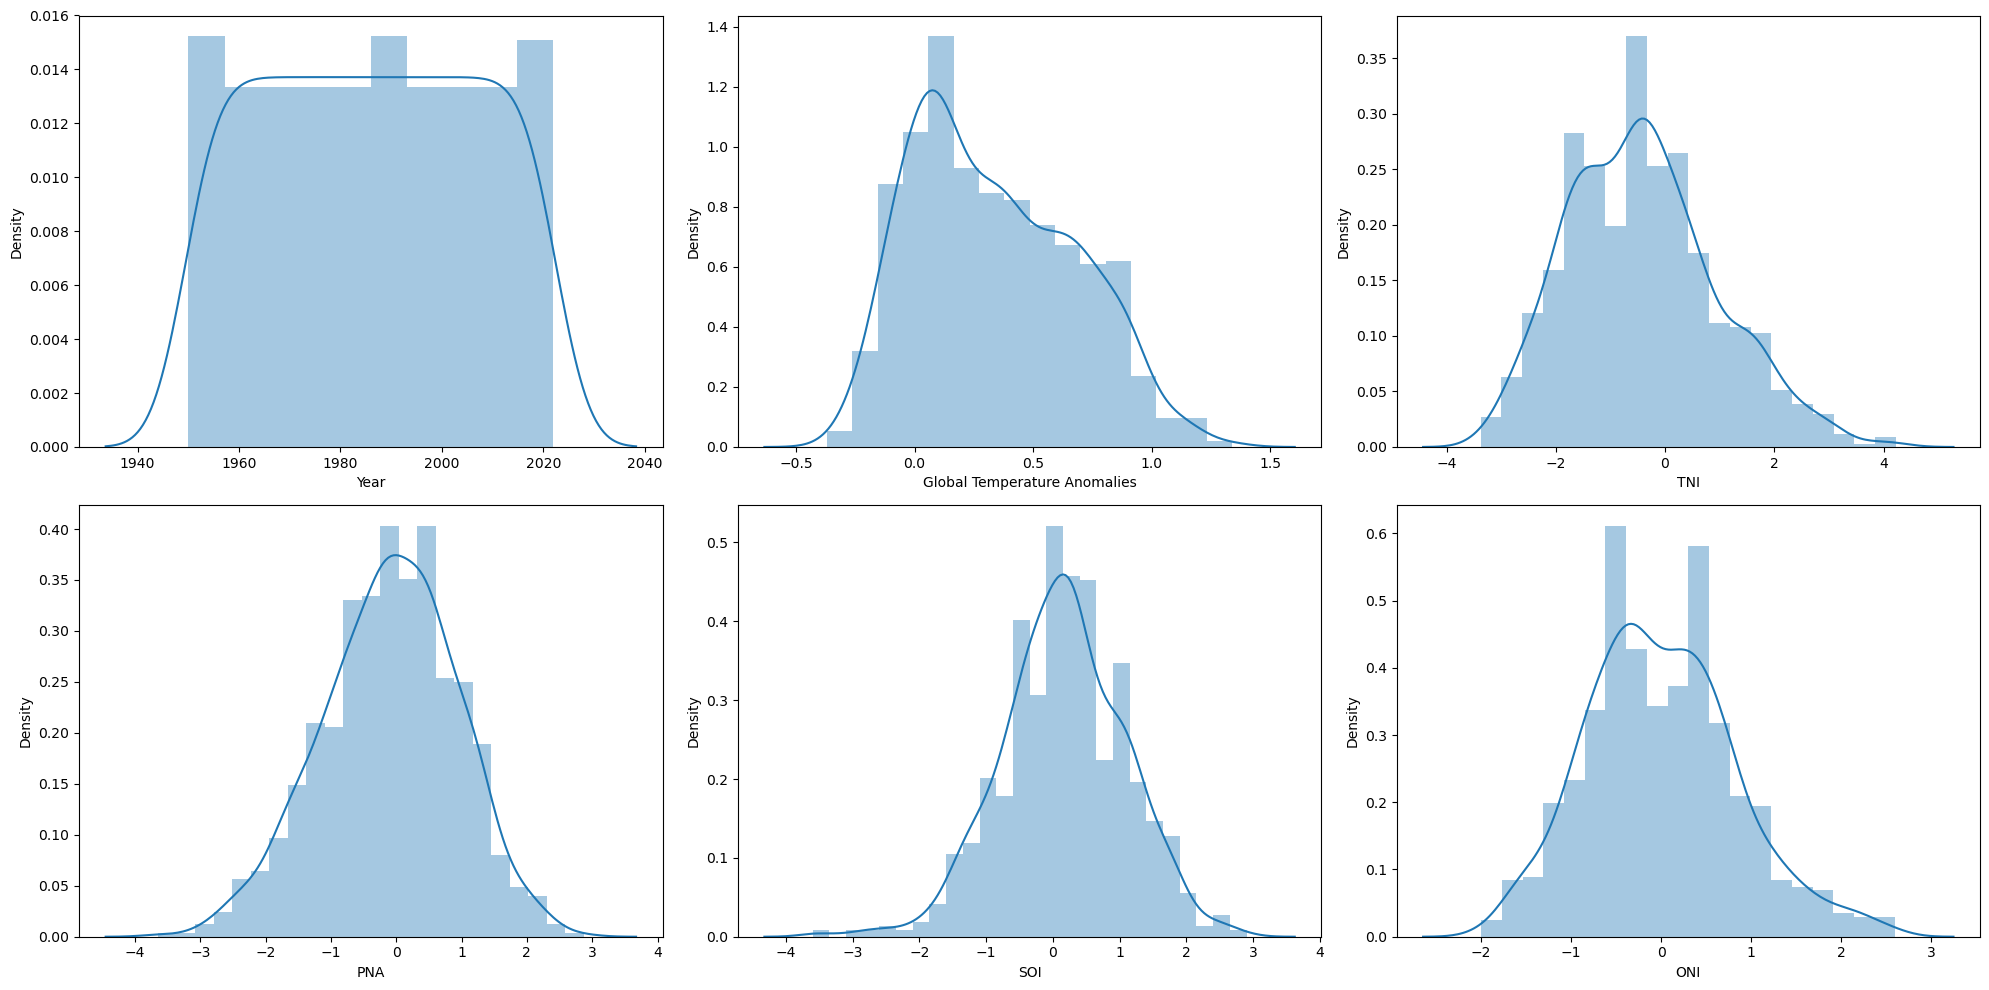

In [391]:
# show histograms of the numerical columns

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

sns.distplot(data['Year'], ax=axs[0, 0])
sns.distplot(data['Global Temperature Anomalies'], ax=axs[0, 1])
sns.distplot(data['TNI'], ax=axs[0, 2])
sns.distplot(data['PNA'], ax=axs[1, 0])
sns.distplot(data['SOI'], ax=axs[1, 1])
sns.distplot(data['ONI'], ax=axs[1, 2])

plt.tight_layout()
plt.show()

In [392]:
# Unique data for categorical columns

print(data["Month"].unique())
print(data["Season (2-Month)"].unique())
print(data["Season (3-Month)"].unique())
print(data["Season (12-Month)"].unique())
print(data["ENSO Phase-Intensity"].unique())

['JAN' 'FEB' 'MAR' 'APR' 'MAY' 'JUN' 'JUL' 'AUG' 'SEP' 'OCT' 'NOV' 'DEC']
['DJ' 'JF' 'FM' 'MA' 'AM' 'MJ' 'JJ' 'JA' 'AS' 'SO' 'ON' 'ND']
['DJF' 'JFM' 'FMA' 'MAM' 'AMJ' 'MJJ' 'JJA' 'JAS' 'ASO' 'SON' 'OND' 'NDJ']
['1950-1951' '1951-1952' '1952-1953' '1953-1954' '1954-1955' '1955-1956'
 '1956-1957' '1957-1958' '1958-1959' '1959-1960' '1960-1961' '1961-1962'
 '1962-1963' '1963-1964' '1964-1965' '1965-1966' '1966-1967' '1967-1968'
 '1968-1969' '1969-1970' '1970-1971' '1971-1972' '1972-1973' '1973-1974'
 '1974-1975' '1975-1976' '1976-1977' '1977-1978' '1978-1979' '1979-1980'
 '1980-1981' '1981-1982' '1982-1983' '1983-1984' '1984-1985' '1985-1986'
 '1986-1987' '1987-1988' '1988-1989' '1989-1990' '1990-1991' '1991-1992'
 '1992-1993' '1993-1994' '1994-1995' '1995-1996' '1996-1997' '1997-1998'
 '1998-1999' '1999-2000' '2000-2001' '2001-2002' '2002-2003' '2003-2004'
 '2004-2005' '2005-2006' '2006-2007' '2007-2008' '2008-2009' '2009-2010'
 '2010-2011' '2011-2012' '2012-2013' '2013-2014' '2014-2015'

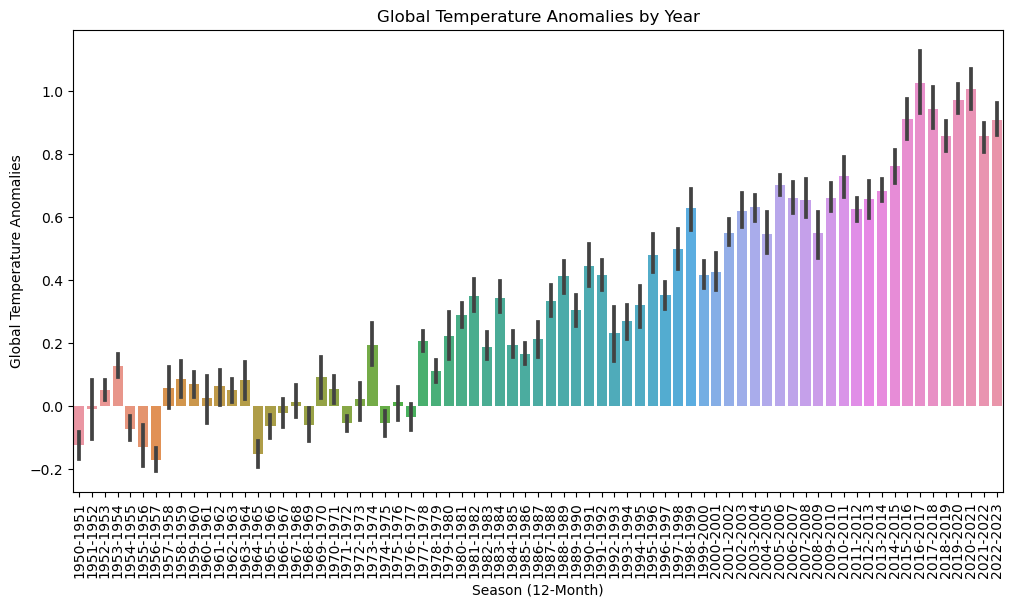

In [408]:
# Global Temperature Anomalies by Year

plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='Season (12-Month)', y='Global Temperature Anomalies')
plt.title('Global Temperature Anomalies by Year')
plt.xlabel('Season (12-Month)')
plt.ylabel('Global Temperature Anomalies')
plt.xticks(rotation=90)
plt.show()

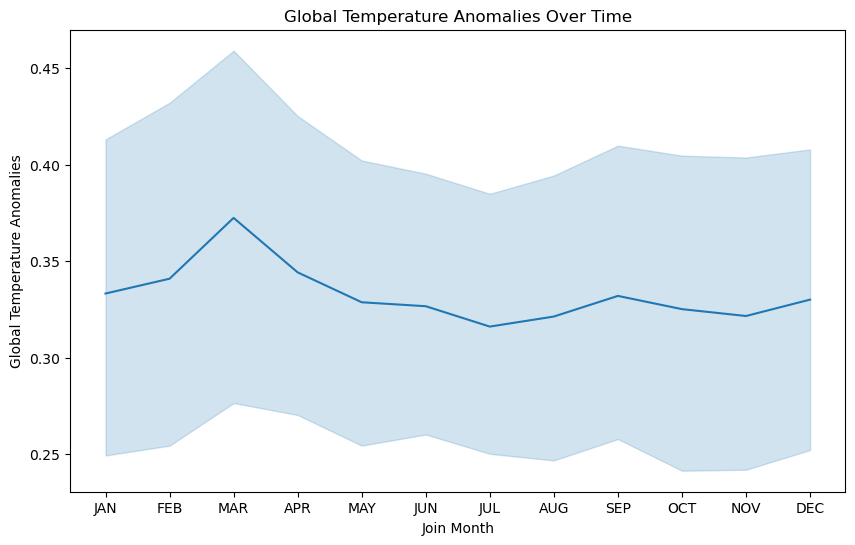

In [411]:
# Global Temperature Anomalies Over Time

plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='Month', y='Global Temperature Anomalies', estimator='mean')
plt.title('Global Temperature Anomalies Over Time')
plt.xlabel('Join Month')
plt.ylabel('Global Temperature Anomalies')
plt.show()

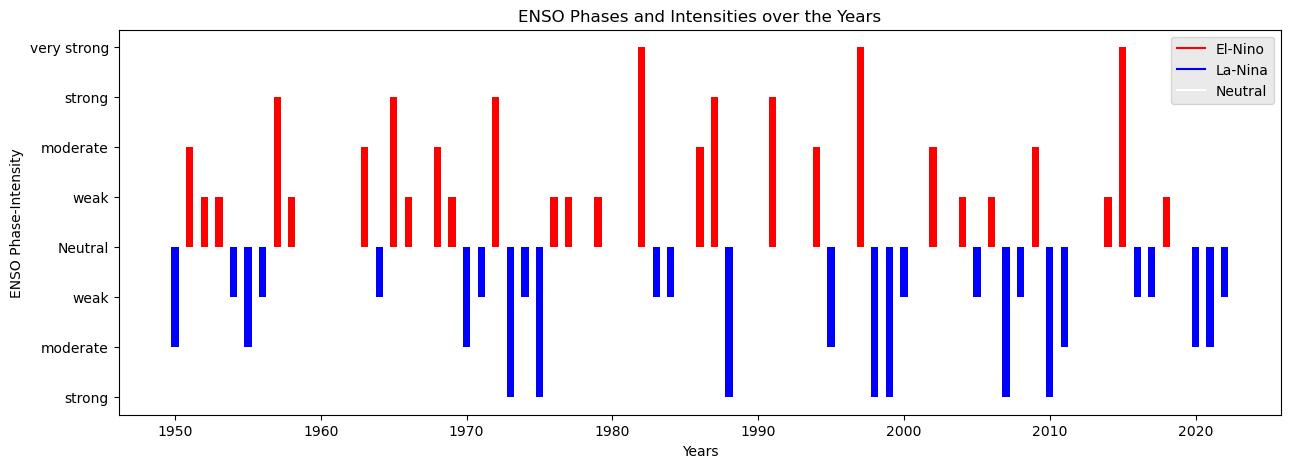

In [418]:
# I found this code on the internet and I found it very interesting and important

# encode enso phases
encoding_enso = {'VSE': 2.0,
                 'SE': 1.5,
                 'ME': 1.0,
                 'WE': 0.5,
                 'N': 0,       # neutral is between -0.4 and +0.4, here we will use 0
                 'WL': -0.5,
                 'ML': -1,
                 'SL': -1.5}
encoded_enso = data['ENSO Phase-Intensity'][::12].map(encoding_enso)

# plot
plt.figure(figsize=(15, 5))
plt.bar(x = data.Year.unique(), 
        height = encoded_enso, 
        width = 0.5,
        color = ['r' if val > 0 else 'b' for val in encoded_enso])
plt.xlabel('Years')
plt.ylabel('ENSO Phase-Intensity')
plt.title('ENSO Phases and Intensities over the Years')

# custom y-axis labels
plt.yticks(ticks = np.arange(-1.5, 2.5, 0.5), 
           labels = ['strong', 'moderate', 'weak', 'Neutral', 
                     'weak', 'moderate', 'strong', 'very strong'])

# custom legends
line_red = mlines.Line2D([0], [0], label='El-Niño', color='r')
line_blue = mlines.Line2D([0], [0], label='La-Niña', color='b')
line_white = mlines.Line2D([0], [0], label='Neutral', color='w')
plt.legend(handles=[line_red, line_blue, line_white], facecolor='#e5e5e5', loc='upper right')

# save and show
# plt.savefig('enso phase intensity.eps', format='eps')
plt.show()

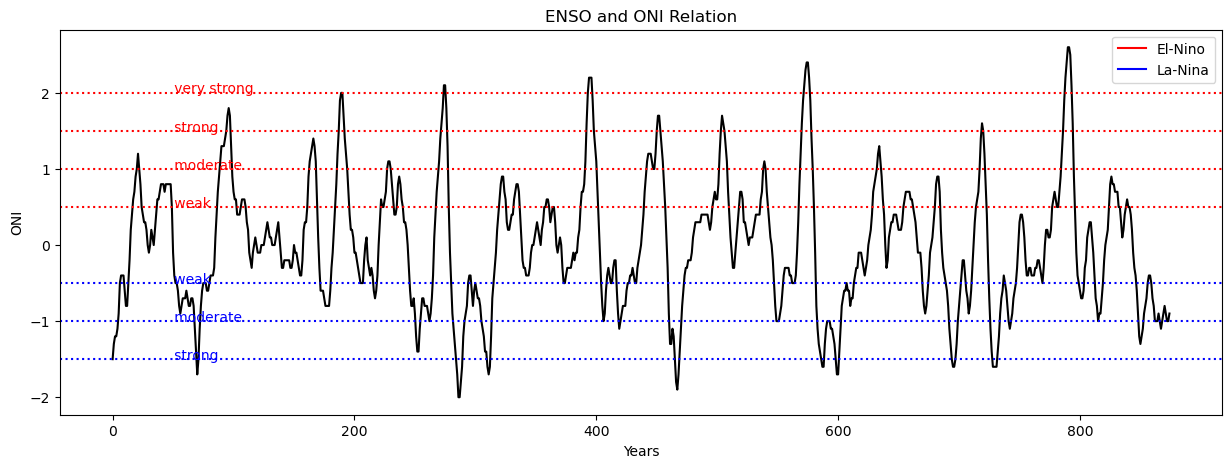

In [423]:
# And another cool code found on the internet

# ONI and ENSO relation

plt.figure(figsize=(15, 5))

# convert dates to numbers to get x-axis range
x = mdates.date2num(data.index)

# plot Year and ONI
plt.plot(data.ONI, color='black')
plt.xlabel('Years')
plt.ylabel('ONI')
plt.title('ENSO and ONI Relation')

# add horizontal lines and labels to define ENSO  and intensity

plt.axhline(y=2, color='r', linestyle=':')
plt.text(x=x[-1], y=2, color='red', s='              very strong')

plt.axhline(y=1.5, color='r', linestyle=':')
plt.text(x=x[-1], y=1.5, color='red', s='              strong')

plt.axhline(y=1, color='r', linestyle=':')
plt.text(x[-1], 1, color='r', s='              moderate')

plt.axhline(y=0.5, color='r', linestyle=':')
plt.text(x[-1], 0.5, color='r', s='              weak')

plt.axhline(y=-0.5, color='b', linestyle=':')
plt.text(x[-1], -0.5, color='b', s='              weak')

plt.axhline(y=-1, color='b', linestyle=':')
plt.text(x[-1], -1, color='b', s='              moderate')

plt.axhline(y=-1.5, color='b', linestyle=':')
plt.text(x[-1], -1.5, color='b', s='              strong')

# custom legends
line_red = mlines.Line2D([0], [0], label='El-Niño', color='r')
line_blue = mlines.Line2D([0], [0], label='La-Niña', color='b')
plt.legend(handles=[line_red, line_blue])

plt.show()

Minimum:-0.37
Mean:0.33
Median:0.29
Mode:0.10
Maximum:1.34



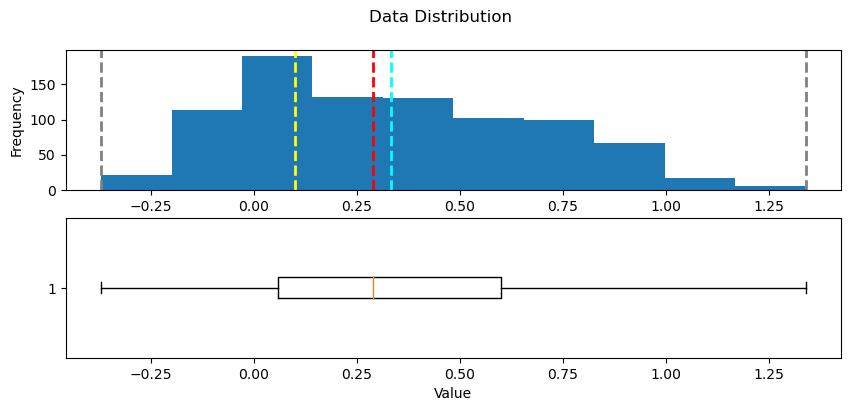

In [430]:
# Create a function that we can re-use
def show_distribution(var_data):
    '''
    This function will make a distribution (graph) and display it
    '''

    # Get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (10,4))

    # Plot the histogram   
    ax[0].hist(var_data)
    ax[0].set_ylabel('Frequency')

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot   
    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel('Value')

    # Add a title to the Figure
    fig.suptitle('Data Distribution')

    # Show the figure
    fig.show()

# Call the function
show_distribution(data['Global Temperature Anomalies'])

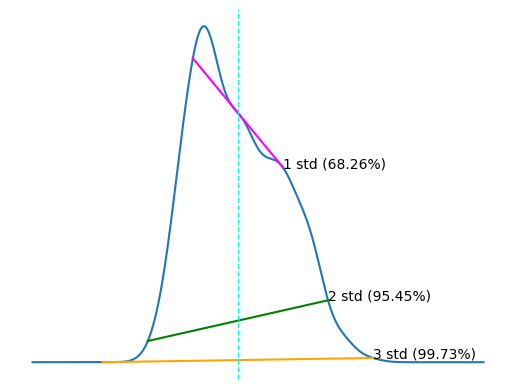

In [431]:
# Get the Grade column
col = data['Global Temperature Anomalies']

# get the density
density = stats.gaussian_kde(col)

# Plot the density
col.plot.density()

# Get the mean and standard deviation
s = col.std()
m = col.mean()

# Annotate 1 stdev
x1 = [m-s, m+s]
y1 = density(x1)
plt.plot(x1,y1, color='magenta')
plt.annotate('1 std (68.26%)', (x1[1],y1[1]))

# Annotate 2 stdevs
x2 = [m-(s*2), m+(s*2)]
y2 = density(x2)
plt.plot(x2,y2, color='green')
plt.annotate('2 std (95.45%)', (x2[1],y2[1]))

# Annotate 3 stdevs
x3 = [m-(s*3), m+(s*3)]
y3 = density(x3)
plt.plot(x3,y3, color='orange')
plt.annotate('3 std (99.73%)', (x3[1],y3[1]))

# Show the location of the mean
plt.axvline(col.mean(), color='cyan', linestyle='dashed', linewidth=1)

plt.axis('off')

plt.show()

## Working in predictions

In [394]:
# Seperate columns by data type

num_data = data[['Year','Global Temperature Anomalies','TNI', 'PNA', 'SOI', 'ONI']]
cat_data = data[['Month','Season (2-Month)','Season (3-Month)','Season (12-Month)','ENSO Phase-Intensity']]

In [395]:
# Here I made the decision to normalize the categorical data once and for all using lebel encoder 
# since I wanted to visualize the correlation map and the OLS with all the data.

lebel = cat_data.apply(LabelEncoder().fit_transform)
lebel

,Month,Season (2-Month),Season (3-Month),Season (12-Month),ENSO Phase-Intensity
0,4,2,2,0,1
1,3,5,5,0,1
2,7,3,3,0,1
3,0,7,7,0,1
4,8,0,0,0,1
...,...,...,...,...,...
870,5,6,6,72,7
871,1,4,4,72,7
872,11,1,1,72,7
873,10,11,11,72,7


In [396]:
data_vis = pd.concat([lebel,num_data],axis=1)
data_vis

,Month,Season (2-Month),Season (3-Month),Season (12-Month),ENSO Phase-Intensity,Year,Global Temperature Anomalies,TNI,PNA,SOI,ONI
0,4,2,2,0,1,1950,-0.20,0.62,-3.65,0.15,-1.50
1,3,5,5,0,1,1950,-0.26,0.45,-1.69,0.15,-1.30
2,7,3,3,0,1,1950,-0.08,0.38,-0.06,0.15,-1.20
3,0,7,7,0,1,1950,-0.16,0.31,-0.23,0.15,-1.20
4,8,0,0,0,1,1950,-0.02,0.12,-0.40,0.15,-1.10
...,...,...,...,...,...,...,...,...,...,...,...
870,5,6,6,72,7,2022,0.88,-0.31,1.96,0.80,-0.80
871,1,4,4,72,7,2022,0.92,-0.28,0.76,1.00,-0.90
872,11,1,1,72,7,2022,0.89,-0.13,0.13,1.60,-1.00
873,10,11,11,72,7,2022,0.96,0.12,0.35,1.70,-1.00


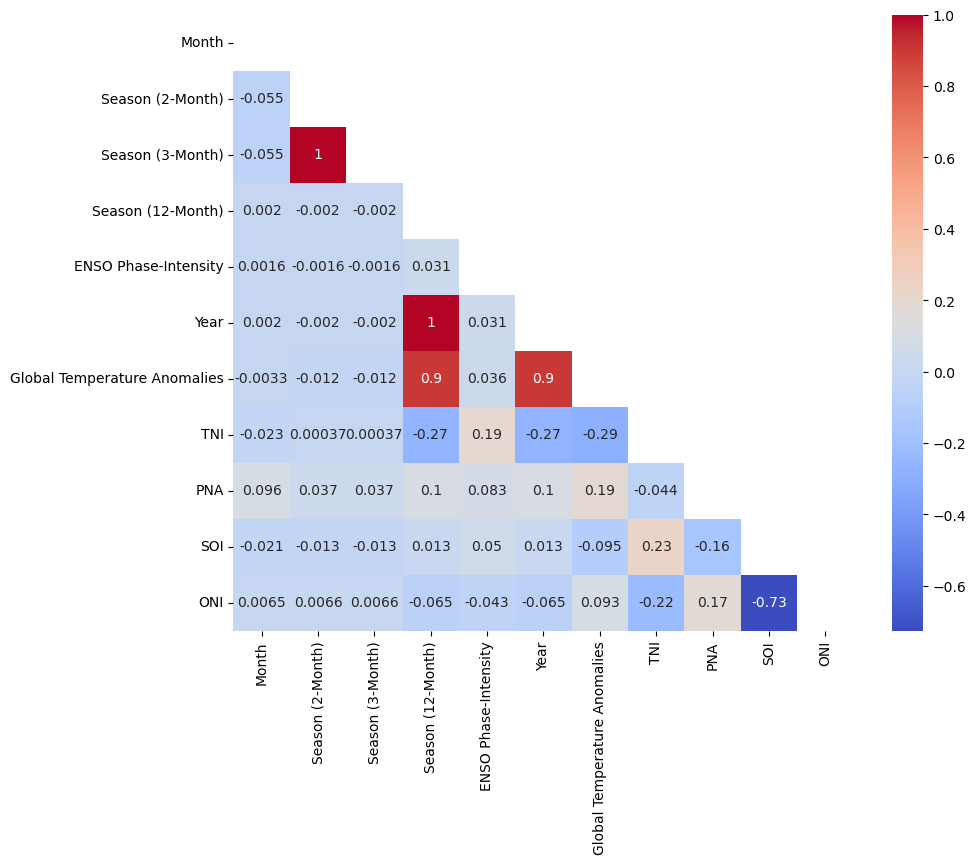

In [397]:
# Correlation map with all data

corr_matrix = data_vis.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm')
plt.show()

In [398]:
# Fit a basic OLS regression
# Here I deleted the SOI and ONI columns since they did not have much relationship with 
# the other data, also with and without them I had the same r-squared

y = data_vis["ENSO Phase-Intensity"]
x = data_vis.drop(["ENSO Phase-Intensity","SOI","ONI"], axis=1)
x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     ENSO Phase-Intensity   R-squared:                       0.052
Model:                              OLS   Adj. R-squared:                  0.046
Method:                   Least Squares   F-statistic:                     7.967
Date:                  Mon, 16 Oct 2023   Prob (F-statistic):           2.21e-08
Time:                          19:58:39   Log-Likelihood:                -1977.6
No. Observations:                   875   AIC:                             3969.
Df Residuals:                       868   BIC:                             4003.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                        -1.278e-08   4.56e-06     -0.003      0.998   -8.97e-06    8.95e-06
Month                           -0.0007      0.023     -0.029      0.977      -0.046       0.044
Season (2-Month)                -0.0014      0.011     -0.120      0.905      -0.024       0.021
Season (3-Month)                -0.0014      0.011     -0.120      0.905      -0.024       0.021
Season (12-Month)                0.0019      0.009      0.211      0.833      -0.015       0.019
Year                             0.0018      0.000     13.759      0.000       0.002       0.002
Global Temperature Anomalies     0.3926      0.549      0.715      0.475      -0.686       1.471
TNI                              0.3872      0.061      6.398      0.000       0.268       0.506
PNA                              0.1821      0.079      2.308      0.021       0.027       0.337
==============================================================================
Omnibus:                     1487.789   Durbin-Watson:                   0.172
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.704
Skew:                           0.151   Prob(JB):                     1.47e-14
Kurtosis:                       1.713   Cond. No.                     1.67e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.24e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [399]:
# Evaluate model performances

X = data_vis.drop("ENSO Phase-Intensity", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models.head()

 24%|██▍       | 10/42 [00:00<00:01, 24.58it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


100%|██████████| 42/42 [00:04<00:00,  9.08it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 612, number of used features: 10
[LightGBM] [Info] Start training from score 3.620915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
XGBRegressor,0.86,0.87,0.84,0.09
ExtraTreesRegressor,0.82,0.83,0.96,0.18
RandomForestRegressor,0.77,0.78,1.10,0.33
GradientBoostingRegressor,0.72,0.73,1.21,0.11
BaggingRegressor,0.72,0.73,1.22,0.04


R-Squared Score:  0.8696414592936195 



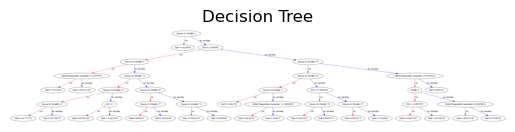

In [400]:
# Evaluate the best model

XGBR = xgb.XGBRegressor()
XGBR.fit(X_train, y_train)
print('R-Squared Score: ', XGBR.score(X_test, y_test), '\n')
plot_tree(XGBR)
plt.title('Decision Tree')
plt.show()

In [424]:
# In this final part I tried to optimize the parameters of the decision tree, 
# although it did not work, I left the code just in case

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

model = GradientBoostingRegressor().fit(X_train,y_train)
alg = GradientBoostingRegressor()
params = {
    'learning_rate': [0.1, 0.5], 'n_estimators': [50, 100], 'max_depth': [3, 5],
    'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]
}
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train, y_train)
print("The best parameter combination is:", gridsearch.best_params_, "\n")

The best parameter combination is: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100} 



## Final Insights
Although I tried to understand this topic, I did not have time to be able to detail many things in depth, which I feel I missed either because I did not understand or because I needed to know more, I had fun doing it and I hope to return to this topic in the future, since it seemed important to me all to see that in the next year (this is the year 2023) El Niño is expected to continue during the northern hemisphere winter (with a probability of over 95% until January-March 2024).